In [14]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
import brian2 as b2
import slab as s
from consts import Paths
from pathlib import Path
import matplotlib.pyplot as plt
from analyze.report import generate_single_result
hrtf_paths = list(Path(Paths.SOFA_DIR).iterdir())
print(hrtf_paths)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[PosixPath('../data/SOFA/dtf_nh156.sofa'), PosixPath('../data/SOFA/dtf_las_nh1012.sofa'), PosixPath('../data/SOFA/hrtf b_nh15.sofa'), PosixPath('../data/SOFA/RIEC_hrir_subject_057.sofa')]


WARNING    /tmp/ipykernel_17203/100673317.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 [py.warnings]


2025-01-27 11:53:28,661 [DEBUG]  ILD is 16.0285339468867
2025-01-27 11:53:28,662 [DEBUG]  calculating ILD between following sounds...
2025-01-27 11:53:28,663 [DEBUG]  ILD is 15.482374896848917
2025-01-27 11:53:28,663 [DEBUG]  calculating ILD between following sounds...
2025-01-27 11:53:28,664 [DEBUG]  ILD is 13.881117583425135
2025-01-27 11:53:28,664 [DEBUG]  calculating ILD between following sounds...
2025-01-27 11:53:28,665 [DEBUG]  ILD is 11.333885046322361
2025-01-27 11:53:28,665 [DEBUG]  calculating ILD between following sounds...
2025-01-27 11:53:28,666 [DEBUG]  ILD is 8.014266973443348
2025-01-27 11:53:28,666 [DEBUG]  calculating ILD between following sounds...
2025-01-27 11:53:28,667 [DEBUG]  ILD is 4.148489850526554
2025-01-27 11:53:28,667 [DEBUG]  calculating ILD between following sounds...
2025-01-27 11:53:28,668 [DEBUG]  ILD is 0.0
2025-01-27 11:53:28,668 [DEBUG]  calculating ILD between following sounds...
2025-01-27 11:53:28,669 [DEBUG]  ILD is 4.148489850526554
2025-01-2

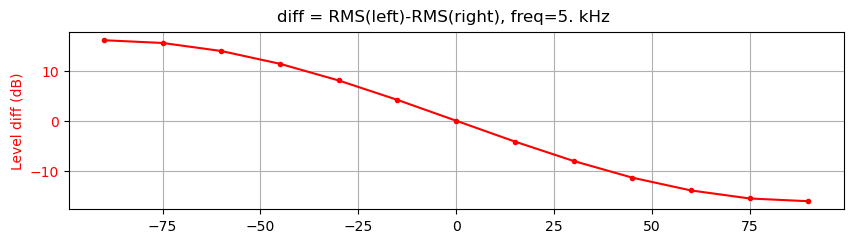

In [9]:
from cochleas.hrtf_utils import synthetic_ild
from utils.custom_sounds import Tone
import brian2hears as b2h
from analyze.sound_analysis import ild

sound = Tone(5000 * b2.Hz, 200 * b2.ms)
sound.sound.level = 80 * b2h.dB
angle_to_ild = {}
PLTWIDTH = 10
angles = list(range(-90, 91, 15))

for angle in angles:
    s_ild = synthetic_ild(sound, angle)
    left = s_ild.left
    right = s_ild.right
    angle_to_ild[angle] = ild(left, right, sound.sound)[0]

fig, ild = plt.subplots(1, sharex=True, figsize=(PLTWIDTH, 2.3))
fig.suptitle(
    f"diff = RMS(left)-RMS(right), freq={sound.frequency}"
    # f"diff = max(|spectrum(left)|)-max(|spectrum(right)|), freq={tone.frequency}"
)

ild.set_ylabel("Level diff (dB)", color="r")
ild.plot(
    angles,
    [angle_to_ild[angle] for angle in angles],
    label="ILD",
    marker=".",
    color="r",
)
ild.tick_params(axis="y", labelcolor="r")
fig.show()

## Vector strength for a specific result, for a specific pop

WARNING    /tmp/ipykernel_386429/593721510.py:99: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 [py.warnings]


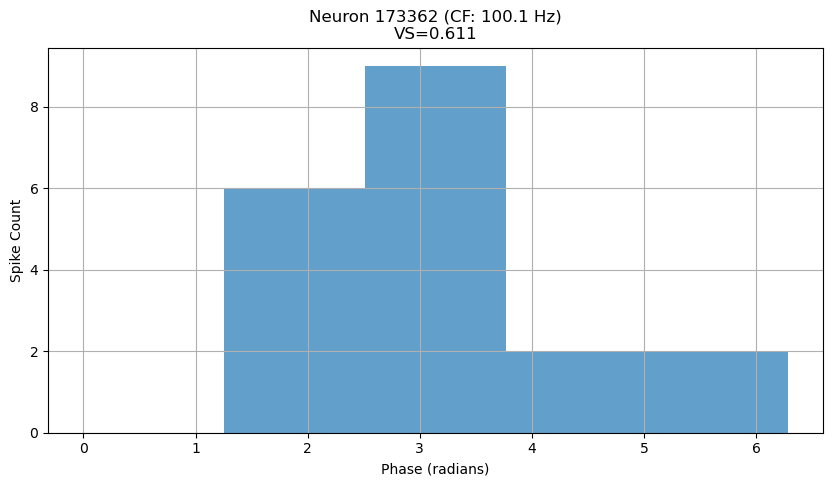

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2
from brian2hears import erbspace
from cochleas.consts import CFMAX, CFMIN
import dill
from collections import defaultdict
from bisect import bisect_left


def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return (myList[0], 0)
    if pos == len(myList):
        return (myList[-1], len(myList))
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return (after, pos)
    else:
        return (before, pos - 1)


def get_spike_phases(spike_times: np.ndarray, frequency: float) -> np.ndarray:
    times_sec = spike_times
    return 2 * np.pi * frequency * (times_sec % (1 / frequency))


def calculate_vector_strength(spike_times: np.ndarray, frequency: float) -> float:
    if len(spike_times) == 0:
        return 0
    phases = get_spike_phases(spike_times, frequency)
    x = np.mean(np.cos(phases))
    y = np.mean(np.sin(phases))
    return np.sqrt(x**2 + y**2)


files = [
    i
    for i in (
        Path(Paths.RESULTS_DIR).absolute()
        / "create_map_of_frequencies_in_LSO_MSO"
        / "withICC&TanCarney&hrtf6_MNTBCs2LSOzero"
    ).iterdir()
    if i.is_file() and str(i).endswith(".pic")
]

POP = "MSO"
SIDE = "R"
ANGLE = 0
i = files[0]

def calculate_vector_strength_from_result(
        # result file (loaded)
        res,
        angle,
        side,
        pop,
        freq=None, # if None: freq = res['basesound'].frequency
        bandwidth=1,
        display=False # if True also return fig, show() in caller function
        ):
    
    ### rest of code

    if not display:
        return (vector_strength, None)
    

    # plot...
    return (fig,vector_strength)

with open(i, "rb") as f:
    res = dill.load(f)
spikes = res["angle_to_rate"][ANGLE][SIDE][POP]

sender2times = defaultdict(list)
for sender, time in zip(spikes["senders"], spikes["times"]):
    sender2times[sender].append(time)
sender2times = {k: np.array(v) / 1000 for k, v in sender2times.items()}

num_neurons = len(spikes["global_ids"])
cf = erbspace(CFMIN, CFMAX, num_neurons)
freq = res["basesound"].frequency

cf_neuron, num_neuron_for_freq = take_closest(cf, freq)
old2newid = {oldid: i for i, oldid in enumerate(spikes["global_ids"])}
new2oldid = {v: k for k, v in old2newid.items()}

## FIXME
# center_neuron_for_freq = take_closest(cf, freq)[1]
# relevant_neurons = range_around_center(
#     center_neuron_for_freq, radius=bandwidth, max_val=num_neurons - 1
# )
# relevant_neurons_ids = [new2oldid[i] for i in relevant_neurons]

id_neuron_for_freq = new2oldid[num_neuron_for_freq]

phases = get_spike_phases(
    spike_times=sender2times[id_neuron_for_freq], frequency=freq / b2.Hz
)
vs = calculate_vector_strength(
    spike_times=sender2times[id_neuron_for_freq], frequency=freq / b2.Hz
)

# plot phases
n_bins = 5
bins = np.linspace(0, 2 * np.pi, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

fig, ax = plt.subplots(1, 1, figsize=(10,5))
hist1, _ = np.histogram(phases, bins=bins)
ax.bar(bin_centers, hist1, width=2 * np.pi / n_bins, alpha=0.7)
ax.set_title(
    f"Neuron {id_neuron_for_freq} (CF: {cf_neuron:.1f} Hz)\nVS={vs:.3f}"
)
ax.set_xlabel("Phase (radians)")
ax.set_ylabel("Spike Count")
fig.show()

## explore map of LSO/MSO freq correspondances


generating complete reports
using erbscale, center neuron for this freq should be (100.1169106 * hertz, 111)
2025-02-04 12:20:16,561 [DEBUG]  {'title': '2025-01-21T22:01:06 100. Hz input, filtered around 100. Hz', 'show_pops': ['MSO'], 'rate': False, 'hist_logscale': True}
2025-02-04 12:20:16,561 [DEBUG]  simulation time=200. ms


pop: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
WARNING    /tmp/ipykernel_386429/3051427553.py:217: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 [py.warnings]


using erbscale, center neuron for this freq should be (0.49933185 * khertz, 427)
2025-02-04 12:20:17,464 [DEBUG]  {'title': '2025-01-21T22:18:46 0.5 kHz input, filtered around 0.5 kHz', 'show_pops': ['MSO'], 'rate': False, 'hist_logscale': True}
2025-02-04 12:20:17,464 [DEBUG]  simulation time=200. ms


pop: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
WARNING    /tmp/ipykernel_386429/3051427553.py:217: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 [py.warnings]


using erbscale, center neuron for this freq should be (0.99969235 * khertz, 635)
2025-02-04 12:20:18,246 [DEBUG]  {'title': '2025-01-21T22:35:58 1. kHz input, filtered around 1. kHz', 'show_pops': ['MSO'], 'rate': False, 'hist_logscale': True}
2025-02-04 12:20:18,246 [DEBUG]  simulation time=200. ms


pop: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
WARNING    /tmp/ipykernel_386429/3051427553.py:217: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 [py.warnings]


using erbscale, center neuron for this freq should be (5.00026944 * khertz, 1211)
2025-02-04 12:20:19,036 [DEBUG]  {'title': '2025-01-21T22:52:53 5. kHz input, filtered around 5. kHz', 'show_pops': ['MSO'], 'rate': False, 'hist_logscale': True}
2025-02-04 12:20:19,037 [DEBUG]  simulation time=200. ms


pop: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]
WARNING    /tmp/ipykernel_386429/3051427553.py:217: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 [py.warnings]
WARNING    /tmp/ipykernel_386429/3051427553.py:223: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 [py.warnings]
WARNING    /tmp/ipykernel_386429/3051427553.py:225: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 [py.warnings]


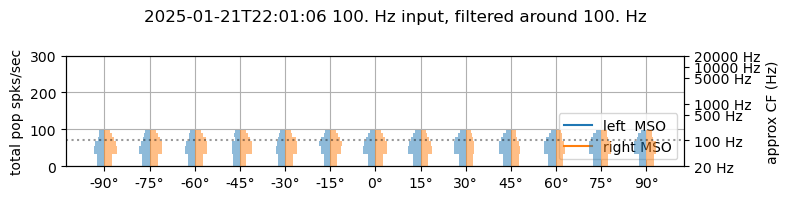

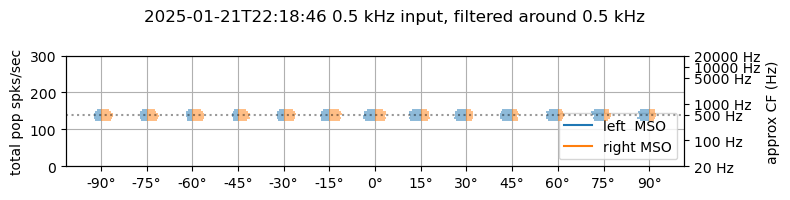

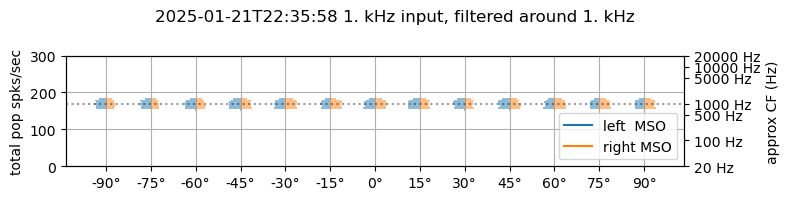

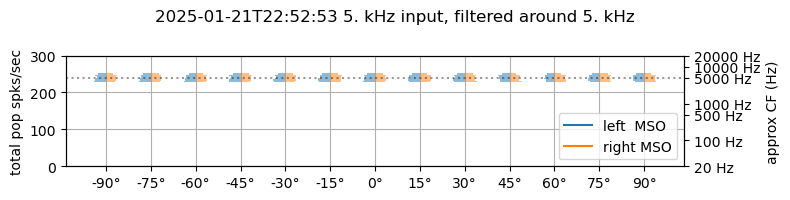

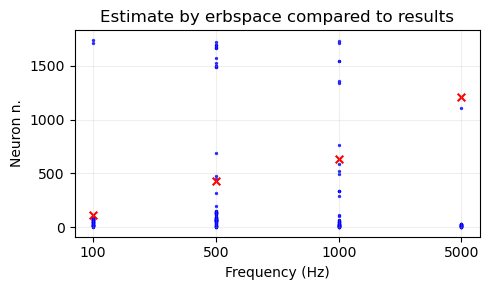

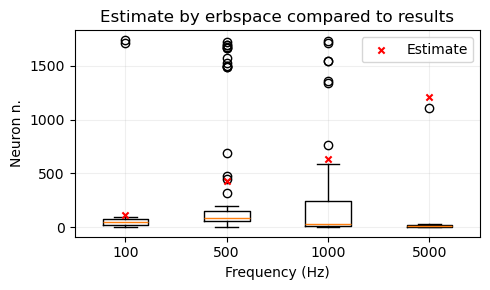

In [2]:
from collections import defaultdict
import dill
from brian2hears import erbspace
from cochleas.consts import CFMAX, CFMIN
import numpy as np
from analyze.report import draw_rate_vs_angle
from bisect import bisect_left


def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return (myList[0], 0)
    if pos == len(myList):
        return (myList[-1], len(myList))
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return (after, pos)
    else:
        return (before, pos - 1)


def plot_estimate_vs_results_scatter(data):
    fig, ax = plt.subplots(figsize=(5, 3))
    freqs = list(data.keys())

    for i, freq in enumerate(freqs):
        results = data[freq]["results"]
        ax.scatter(
            [i] * len(results),
            results,
            color="blue",
            alpha=0.8,
            s=2,
            label="Results" if freq == list(data.keys())[0] else "",
        )

        estimate = data[freq]["estimate"]
        ax.scatter(
            i,
            estimate,
            marker="x",
            color="red",
            s=30,
            label="Estimate" if freq == list(data.keys())[0] else "",
        )

    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Neuron n.")
    ax.set_xticks(range(0, len(freqs)))
    ax.set_xticklabels([f"{freq:g}" for freq in freqs])
    ax.set_title("Estimate by erbspace compared to results")
    # ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.2)
    plt.tight_layout()
    return fig, ax


def plot_estimate_vs_results_boxplot(data):
    fig, ax = plt.subplots(figsize=(5, 3))

    frequencies = list(data.keys())
    results_data = [np.array(data[freq]["results"]) for freq in frequencies]
    estimates = [data[freq]["estimate"] for freq in frequencies]

    bp = ax.boxplot(results_data)
    ax.scatter(
        range(1, len(frequencies) + 1),
        estimates,
        marker="x",
        color="red",
        s=20,
        zorder=3,
        label="Estimate",
    )
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Neuron n.")
    ax.legend()
    ax.set_xticks(range(1, len(frequencies) + 1))
    ax.set_xticklabels([f"{freq:g}" for freq in frequencies])
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.set_title("Estimate by erbspace compared to results")
    plt.tight_layout()
    return fig, ax


def firing_neurons_distribution(x):
    "returns {neuron_id: num_spikes}"
    n2s = {id: 0 for id in x["global_ids"]}
    for sender in x["senders"]:
        n2s[sender] += 1
    return n2s


# results_dir = (
#     Path(Paths.RESULTS_DIR).absolute()
#     / "create_map_of_frequencies_in_LSO_MSO"
#     / "withICC&ppg&hrtf7"
# )
# results_dir = (
#     Path(Paths.RESULTS_DIR).absolute()
#     / "create_map_of_frequencies_in_LSO_MSO"
#     / "withICC&gammatone&hrtf7_gamm"
# )
# results_dir = (
#     Path(Paths.RESULTS_DIR).absolute()
#     / "create_map_of_frequencies_in_LSO_MSO"
#     / "withICC&TanCarney&increase_LSO_spikesMNTB-20level80dBLSOCm50"
# )
results_dir = (
    Path(Paths.RESULTS_DIR).absolute()
    / "create_map_of_frequencies_in_LSO_MSO"
    / "withICC&TanCarney&hrtf6_MNTBCs2LSOzero"
)

print("generating complete reports")
files = [i for i in results_dir.iterdir() if i.is_file() and str(i).endswith(".pic")]

freq_to_neur = defaultdict(dict)
POP = "MSO"


def range_around_center(center, radius, min_val=0, max_val=np.iinfo(np.int64).max):
    start = max(min_val, center - radius)
    end = min(max_val + 1, center + radius + 1)
    return np.arange(start, end)


def filter_spikes_close_to_freq(res, freq, pops):
    a2r = res["angle_to_rate"]
    for pop in pops:
        for side in ["L", "R"]:
            num_neurons = len(a2r[0][side][pop]["global_ids"])
            cf = erbspace(CFMIN, CFMAX, num_neurons)
            old2newid = {
                oldid: i for i, oldid in enumerate(a2r[0][side][pop]["global_ids"])
            }
            new2oldid = {v: k for k, v in old2newid.items()}

            center_neuron_for_freq = take_closest(cf, freq)[1]
            relevant_neurons = range_around_center(
                center_neuron_for_freq, radius=100, max_val=num_neurons - 1
            )
            relevant_neurons_ids = [new2oldid[i] for i in relevant_neurons]
            # we are assuming that the network does not change between angles, which i believe is a reasonable assumption
            for angle in a2r.keys():
                # print(f"working on {pop}{side}{angle}")
                # print(f"acceptable neurons are {relevant_neurons}")
                # print(f"acceptable neurons are {relevant_neurons_ids}")
                senders = a2r[angle][side][pop]["senders"]
                times = a2r[angle][side][pop]["times"]
                # ranges would be more efficient, but the overhead of conversion + extra code + maybe we decide to select them non contiguously...
                mask = np.isin(senders, relevant_neurons_ids)
                a2r[angle][side][pop]["senders"] = senders[mask]
                # print(f"which means that the result is {senders[mask]}")
                a2r[angle][side][pop]["times"] = times[mask]

    res["angle_to_rate"] = a2r

    return res


for i in files:
    with open(i, "rb") as f:
        res = dill.load(f)
    angle_to_rate = res["angle_to_rate"]
    angles = list(angle_to_rate.keys())
    freq = res["basesound"].frequency
    active_in_freq = set
    for angle in angles:
        x = angle_to_rate[angle]["L"][POP]
        old2newid = {oldid: i for i, oldid in enumerate(x["global_ids"])}
        distr = firing_neurons_distribution(x)
        # print(distr)
        neur_idx_to_spks = sorted(
            [(old2newid[k], v) for k, v in distr.items()],
            key=lambda x: x[1],
            reverse=True,
        )
        neur_idx_to_spks = {k: v for k, v in neur_idx_to_spks[:10]}

        active_in_freq = active_in_freq.union(set(neur_idx_to_spks.keys()))
    # print(f"for frequency {freq}, active neurons are {sorted(all_active_in_freq)}")
    cf = erbspace(CFMIN, CFMAX, len(angle_to_rate[0]["L"][POP]["global_ids"]))
    print(
        f"using erbscale, center neuron for this freq should be {take_closest(cf,freq)}"
    )
    freq_to_neur[freq / b2.Hz]["results"] = sorted(active_in_freq)
    freq_to_neur[freq / b2.Hz]["estimate"] = take_closest(cf, freq)[1]
    # fig = draw_rate_vs_angle(
    #     res,
    #     f"{i.name:.19} {freq}",
    #     rate=False,
    #     hist_logscale=True,
    #     show_pops=[POP],
    #     ylim=[0, 3000],
    #     show_freq=True,
    # )
    res = filter_spikes_close_to_freq(res, freq, pops=[POP])
    # res = filter_spikes_close_to_freq(res, 1000 * b2.Hz, pops=[POP])

    fig = draw_rate_vs_angle(
        res,
        f"{i.name:.19} {freq} input, filtered around {freq}",
        rate=False,
        hist_logscale=True,
        show_pops=[POP],
        ylim=[0, 300],
        show_freq=True,
    )
    fig.show()
    del res
# print(freq_to_neur)


fig, ax = plot_estimate_vs_results_scatter(freq_to_neur)
fig.show()
fig, ax = plot_estimate_vs_results_boxplot(freq_to_neur)
fig.show()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

2025-01-16 00:37:03,290 [DEBUG]  genenerating spikes for {'sound': <utils.custom_sounds.WhiteNoise object at 0x7f3f587d0d40>, 'angle': -45, 'plot_spikes': True, 'hrtf_params': {'subj_number': 7, 'ild_only': True, 'itd_remove_strategy': 'estimate_from_hrtf'}}
2025-01-16 00:37:03,323 [DEBUG]  calculating ITD between following sounds...
2025-01-16 00:37:03,327 [INFO ]  {'left_start_time': 5.6462585 * msecond, 'right_start_time': 6.12244898 * msecond}
2025-01-16 00:37:03,328 [INFO ]  calculated ITD of -0.47619048 ms. check graphical output for confirmation.
2025-01-16 00:37:03,328 [DEBUG]  current ITD is -0.47619048 ms
2025-01-16 00:37:03,328 [DEBUG]  synthetic ITD 

IHCsim:   0%|          | 0/10 [00:00<?, ?it/s]Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f3f62f9c540>
Traceback (most recent call last):
  File "/home/paolo/programs/micromamba/envs/hears/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 
IHCsim: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


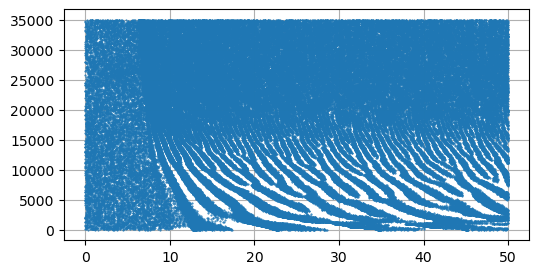

2025-01-16 00:37:13,266 [DEBUG]  working on ear R...


IHCsim: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


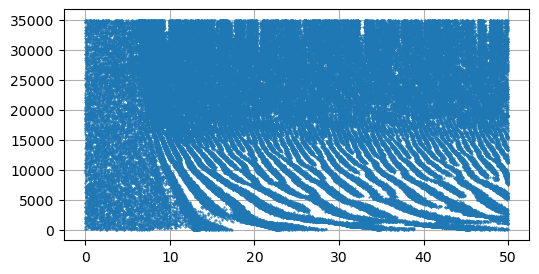

2025-01-16 00:37:22,443 [INFO ]  generation complete.


In [5]:
import brian2 as b2
import brian2hears as b2h
import nest
import numpy as np
from brian2 import *
from brian2hears import *

from cochleas.anf_utils import load_anf_response
from cochleas.GammatoneCochlea import sound_to_spikes as s2sGamm
from cochleas.TanCarneyCochlea import sound_to_spikes
from models.InhModel.params import Parameters as InhParam
from utils.custom_sounds import Tone, WhiteNoise
plt.close()
nest.set_verbosity("M_ERROR")

sound = WhiteNoise(50 * b2.ms, 80 * b2h.dB)
ANGLE = -45
params = InhParam()
# spikes_tc = s2sGamm.call(sound, ANGLE, params.cochlea["gammatone"], True)
spikes_real = sound_to_spikes.call(sound, ANGLE, params.cochlea["TanCarney"], True)


### Show spikes for a specific population/with a specific title

In [3]:
from analyze.report import (
    draw_rate_vs_angle,
    generate_multi_inputs_single_net,
    draw_single_angle_histogram,
)
import dill

POP = 'MSO'

for sel in [
    # "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&gammatone&higherrateMSO/2024-11-15T11:48:24&tone_100.Hz_70dB&gammatone&withICC&higherrateMSO.pic",
    # "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&gammatone&final/2024-11-15T16:36:48&tone_0.5kHz_70dB&gammatone&withICC&final.pic",
    # "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&gammatone&final/2024-11-15T16:41:34&tone_0.8kHz_70dB&gammatone&withICC&final.pic",
    # "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&gammatone&final/2024-11-15T16:45:33&tone_1.kHz_70dB&gammatone&withICC&final.pic",
    # "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&gammatone&final/2024-11-15T17:07:45&tone_5.kHz_70dB&gammatone&withICC&final.pic",
    # "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&gammatone&final/2024-11-15T17:12:08&tone_10.kHz_70dB&gammatone&withICC&final.pic",
    "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&TanCarney&final/2024-11-15T15:30:45&tone_100.Hz_70dB&TanCarney&withICC&final.pic",
    "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&TanCarney&final/2024-11-15T15:35:41&tone_0.5kHz_70dB&TanCarney&withICC&final.pic",
    "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&TanCarney&final/2024-11-15T15:41:05&tone_0.8kHz_70dB&TanCarney&withICC&final.pic",
    "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&TanCarney&final/2024-11-15T15:57:58&tone_1.kHz_70dB&TanCarney&withICC&final.pic",
    # "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&TanCarney&final/2024-11-15T17:16:44&tone_5.kHz_70dB&TanCarney&withICC&final.pic",
    # "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&TanCarney&final/2024-11-15T17:21:29&tone_10.kHz_70dB&TanCarney&withICC&final.pic",
]:
    with open(sel, "rb") as f:
        res = dill.load(f)
        fig = draw_rate_vs_angle(
            res,
            f"",
            # f"MSO spikes for tone {res['basesound'].frequency}, $\Delta t_{'{'}inhi{'}'}=-0.4ms$,$\Delta t_{'{'}inhc{'}'}=0.2ms$",
            rate=False,
            show_pops=[POP],
            # ylim=[15000,30000]
            # ylim=[0,3100],
            show_hist=False
        )
        # fig = draw_single_angle_histogram(
        #     res,
        #     angle=0,
        #     fontsize=15
        #     # population=SBC"
        # )
        fig.show()
        fig.savefig(
            f"/home/paolo/Documents/school/master/polimi/thesis/polithesis/manuscript/pres/highresnew/{res["conf"]["cochlea_type"]}-{POP}-{res['basesound'].frequency}-nohist.png",
            # f"/home/paolo/Documents/school/master/polimi/thesis/polithesis/manuscript/pres/highresnew/SBC-example.png",
            transparent=True,
            dpi=600,
        )
        del res

2024-12-16 11:53:44,282 [DEBUG]  {'title': '', 'show_pops': ['MSO'], 'rate': False, 'hist_logscale': True}
2024-12-16 11:53:44,283 [DEBUG]  simulation time=200. ms


pop: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]
WARNING    /tmp/ipykernel_12546/4029643018.py:42: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown
 [py.warnings]


2024-12-16 11:53:44,780 [DEBUG]  {'title': '', 'show_pops': ['MSO'], 'rate': False, 'hist_logscale': True}
2024-12-16 11:53:44,781 [DEBUG]  simulation time=200. ms


pop: 100%|██████████| 1/1 [00:00<00:00, 14.85it/s]
WARNING    /tmp/ipykernel_12546/4029643018.py:42: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown
 [py.warnings]


2024-12-16 11:53:45,282 [DEBUG]  {'title': '', 'show_pops': ['MSO'], 'rate': False, 'hist_logscale': True}
2024-12-16 11:53:45,282 [DEBUG]  simulation time=200. ms


pop: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]
WARNING    /tmp/ipykernel_12546/4029643018.py:42: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown
 [py.warnings]


2024-12-16 11:53:45,749 [DEBUG]  {'title': '', 'show_pops': ['MSO'], 'rate': False, 'hist_logscale': True}
2024-12-16 11:53:45,749 [DEBUG]  simulation time=200. ms


pop: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]
WARNING    /tmp/ipykernel_12546/4029643018.py:42: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown
 [py.warnings]


### show best ITD for all MSO neurons for a specific input

neur of interest is 119409, which is the one spiking the most at 15


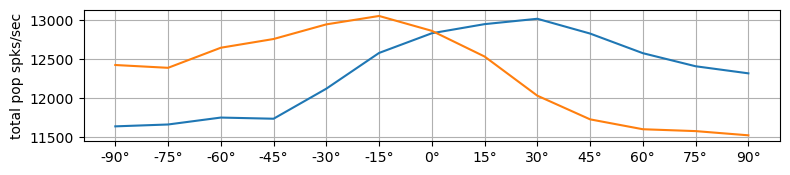

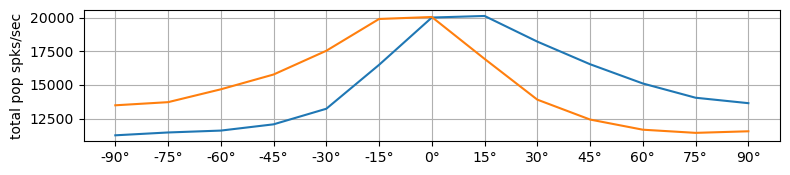

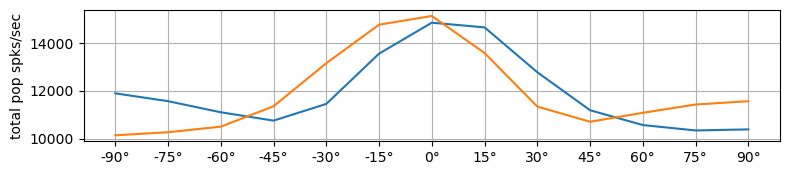

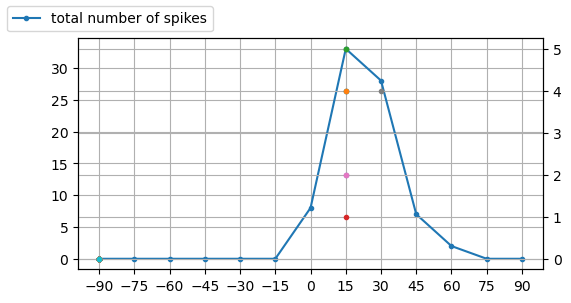

In [4]:
from collections import defaultdict
from analyze.report import draw_rate_vs_angle, generate_multi_inputs_single_net
import dill
import numpy as np

plt.close()


def spikest_neuron(d):
    times = d["times"]
    senders = d["senders"]
    id2spike = defaultdict(int)
    for i in senders:
        id2spike[i] += 1
    max_spikes = max(list(id2spike.values()))

    spikiest_neur = list(id2spike.keys())[np.argmax(list(id2spike.values()))]
    return spikiest_neur, max_spikes


def single_neuron_rate(data, check_angle=30):
    a2r = data["angle_to_rate"]
    angles = list(a2r.keys())
    fig, ax = plt.subplots(1, 1)
    num_neur = []
    num_spike = []
    neur2spikebyangle = defaultdict(list)
    single_neur_spike = []
    relevant_neuron, spikes = spikest_neuron(a2r[check_angle]["L"]["MSO"])
    relevant_neurons = [
        relevant_neuron,
        relevant_neuron + 1,
        relevant_neuron + 2,
        relevant_neuron + 3,
        relevant_neuron + 4,
        relevant_neuron + 5,
    ]
    relevant_neurons = a2r[0]['L']['MSO']['global_ids']

    for angle in angles:
        d = a2r[angle]["L"]["MSO"]
        times = d["times"]
        senders = d["senders"]
        num_neur.append(len(set(senders)))
        num_spike.append(len(times))
        id2spike = defaultdict(int)
        for i in senders:
            id2spike[i] += 1
        for n in relevant_neurons:
            neur2spikebyangle[n].append(id2spike[n])
    ax.plot(angles, num_spike, ".-", label="total number of spikes")
    fig.legend(loc='upper left')

    ax2 = ax.twinx()
    for n, spikes in neur2spikebyangle.items():
        # ax2.plot(angles, spikes, ".-", label=f"spikes neur of interest {n}")
        angle_max_spikes = angles[np.argmax(spikes)]
        ax2.plot(angle_max_spikes, max(spikes), ".-", label=f"spikes neur of interest {n}")
    ax.set_xticks(angles)
    # fig.legend()
    print(
        f"neur of interest is {relevant_neuron}, which is the one spiking the most at {check_angle}"
    )
    plt.show()


for sel in [
    "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&ppg&ppgcheck/2024-11-17T13:13:09&tone_100.Hz_70dB&ppg&withICC&ppgcheck.pic"
    # "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&TanCarney&crazystronginh/2024-11-16T23:41:04&tone_0.5kHz_70dB&TanCarney&withICC&crazystronginh.pic"
]:
    with open(sel, "rb") as f:
        res = dill.load(f)
        single_neuron_rate(res, 15)
# best results with SBC 10, but they do not correspond to our metric

### Plot single scatterplot

In [ ]:
import brian2 as b2
import brian2hears as b2h
import nest
import numpy as np
from brian2 import *
from brian2hears import *

from cochleas.anf_utils import load_anf_response
from cochleas.GammatoneCochlea import sound_to_spikes as s2sGamm
from cochleas.TanCarneyCochlea import sound_to_spikes
from models.InhModel.params import Parameters as InhParam
from utils.custom_sounds import Tone, WhiteNoise

nest.set_verbosity("M_ERROR")

sound = WhiteNoise(100 * b2.ms, 80 * b2h.dB)
ANGLE = -90
params = InhParam()

# spikes_tc = s2sGamm.call(sound, ANGLE, params.cochlea["gammatone"], True)
spikes_real = sound_to_spikes.call(sound, ANGLE, params.cochlea["TanCarney"], True)

### Plot ITD and ILD derived from HRTF effect, for various HRTF and various frequencies

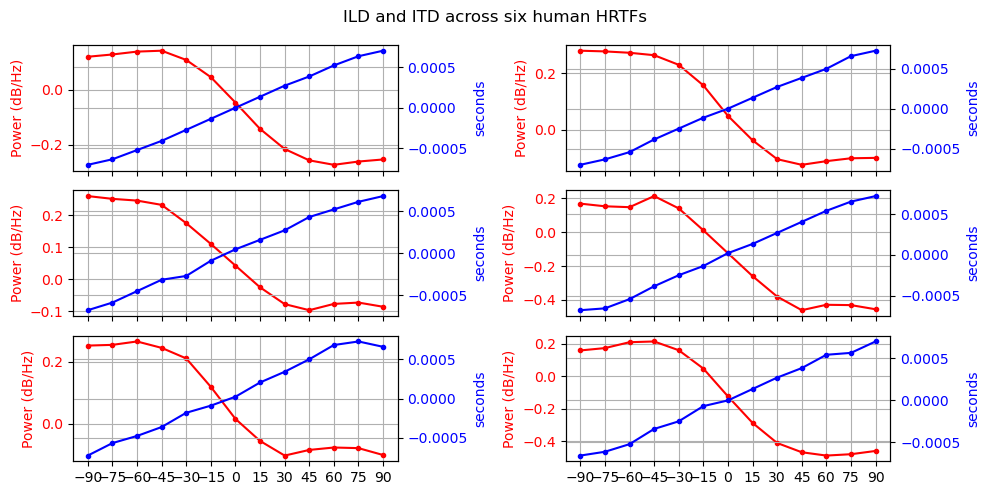

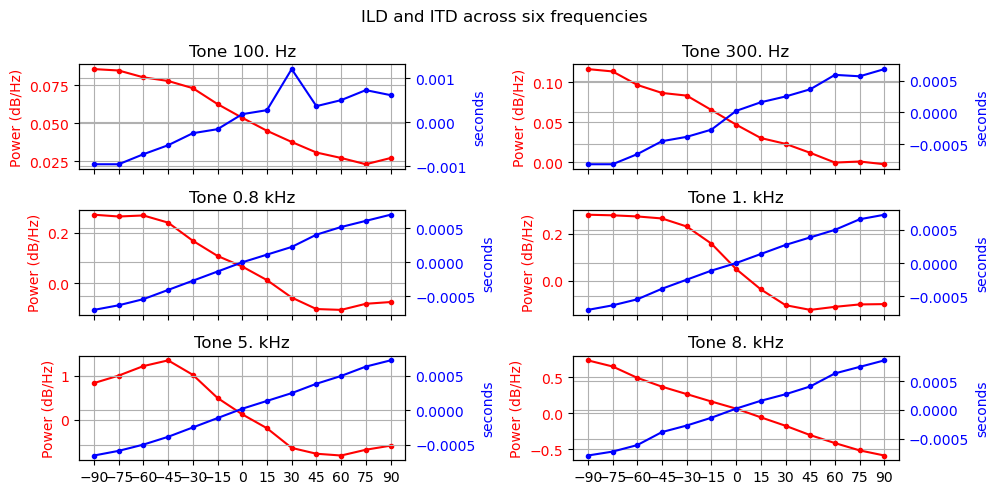

In [5]:
from analyze import sound_analysis as SA
from cochleas.GammatoneCochlea import run_hrtf
from utils.custom_sounds import Tone
from utils.log import logger
import logging


def draw_ITD_ILD(tone, angles, ild, subj_number, title=None):
    prev_level = logger.level
    logger.setLevel(logging.WARNING)
    # itd and ild functions are VERY verbose
    angle_to_ild = {}
    angle_to_itd = {}
    for angle in angles:
        binaural_sound = run_hrtf(
            tone,
            angle,
            subj_number,
        )
        left = binaural_sound.left
        right = binaural_sound.right
        angle_to_itd[angle] = SA.itd(left, right)
        ild_res, all_freq_diff = SA.ild(left, right, tone.sound)
        angle_to_ild[angle] = ild_res

        # total_diff = np.sum(all_freq_diff)
    ild.set_ylabel("Power (dB/Hz)", color="r")
    ild.plot(
        angles,
        [angle_to_ild[angle] for angle in angles],
        label="ILD",
        marker=".",
        color="r",
    )
    ild.tick_params(axis="y", labelcolor="r")
    itd = ild.twinx()
    itd.set_ylabel("seconds", color="b")
    itd.plot(
        angles,
        [angle_to_itd[angle] for angle in angles],
        label="ITD",
        marker=".",
        color="b",
    )
    itd.tick_params(axis="y", labelcolor="b")
    if title is not None:
        ild.set_title(title)
    plt.setp([ild, itd], xticks=angles)
    logger.level = prev_level
    return


from typing import Iterable


def flatten(items):
    """Yield items from any nested iterable.
    from https://stackoverflow.com/a/40857703
    """
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x


def wrap_to_avoid_polluting():
    plt.close()
    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(10, 5))
    axs = flatten(axs)
    tone = Tone(1000 * b2.Hz)
    angles = list(range(-90, 91, 15))
    for ax, subj_number in zip(axs, [0, 1, 2, 4, 5, 6, 7]):  # avoid 3 because it SUCKS
        draw_ITD_ILD(tone, angles, ax, subj_number)
    fig.suptitle("ILD and ITD across six human HRTFs")
    fig.tight_layout()
    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(10, 5))
    axs = flatten(axs)
    frequencies = [100, 300, 800, 1000, 5000, 8000] * b2.Hz
    tones = [Tone(i) for i in frequencies]
    angles = list(range(-90, 91, 15))
    for ax, tone, freq in zip(axs, tones, frequencies):
        draw_ITD_ILD(tone, angles, ax, 1, title=f"Tone {freq}")
    fig.suptitle("ILD and ITD across six frequencies")
    fig.tight_layout()


wrap_to_avoid_polluting()

In [6]:

from analyze.report import generate_network_vis
from pathlib import Path
import dill

sel = Path(
    "/home/paolo/Documents/school/master/polimi/thesis/polithesis/results/produce_for_thesis/withICC&gammatone&final/2024-11-15T17:12:08&tone_10.kHz_70dB&gammatone&withICC&final.pic"
)
print(sel.name.replace('.pic', '.png'))

with open(sel, "rb") as f:
    res = dill.load(f)
    generate_network_vis(res, sel.parent / sel.name.replace('.pic', '.png'))

2024-11-15T17:12:08&tone_10.kHz_70dB&gammatone&withICC&final.png


In [7]:
hrtf = s.HRTF(hrtf_paths[2])
# print(hrtf.n_sources)
# fig, ax = plt.subplots(2)
# sourceidx = hrtf.cone_sources(0)
# ax[0].set_title("waterfall plot")
# ax[1].set_title("image plot")
# hrtf.plot_tf(sourceidx, ear='left', axis=ax[0], show=False, kind="waterfall")
# hrtf.plot_tf(sourceidx, ear='left', axis=ax[1], show=False, kind="image")
# plt.tight_layout()
# plt.show()


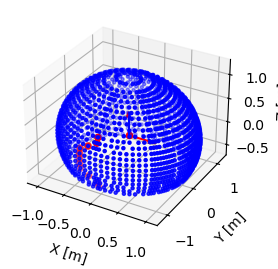

In [8]:
import brian2 as b2
import brian2hears as b2h
from utils.custom_sounds import Tone
import numpy as np
plt.close()
hrtf = s.HRTF(hrtf_paths[2])
# hrtf = s.HRTF.kemar()
input = Tone(100 * b2.Hz, 100 * b2.ms)


sourceidx = hrtf.cone_sources(-55, False)
hrtf.plot_sources(sourceidx)

# bin = hrtf.apply(sourceidx, s.Sound(input.sound))


# res = s.HRTF(hrtf_paths[2]).interpolate(-45,0).apply(s.Sound(input.sound).resample())
# print(res)


In [9]:
# next try SOFAR it seems integrated with pyfar